In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.ensemble import IsolationForest

In [5]:
path_13 = 'data/battery_13_500.csv'
df_13 = pd.read_csv(path_13)

In [6]:
# Voy a necesitar solamente los registros de temperatura
df_temp = df_13.copy()
df_temp['obs'] = range(1, len(df_temp)+1)

## Serie de Tiempo para Temperature

In [7]:
df_temp = df_temp[['obs','time', 'temperature_battery']]
df_temp.head()

obs         time  temperature_battery
0    1  1746819.055               22.668
1    2  1746820.073               22.668
2    3  1746821.115               22.668
3    4  1746822.133               22.668
4    5  1746823.150               22.664

In [8]:
df_temp.shape

(500, 3)

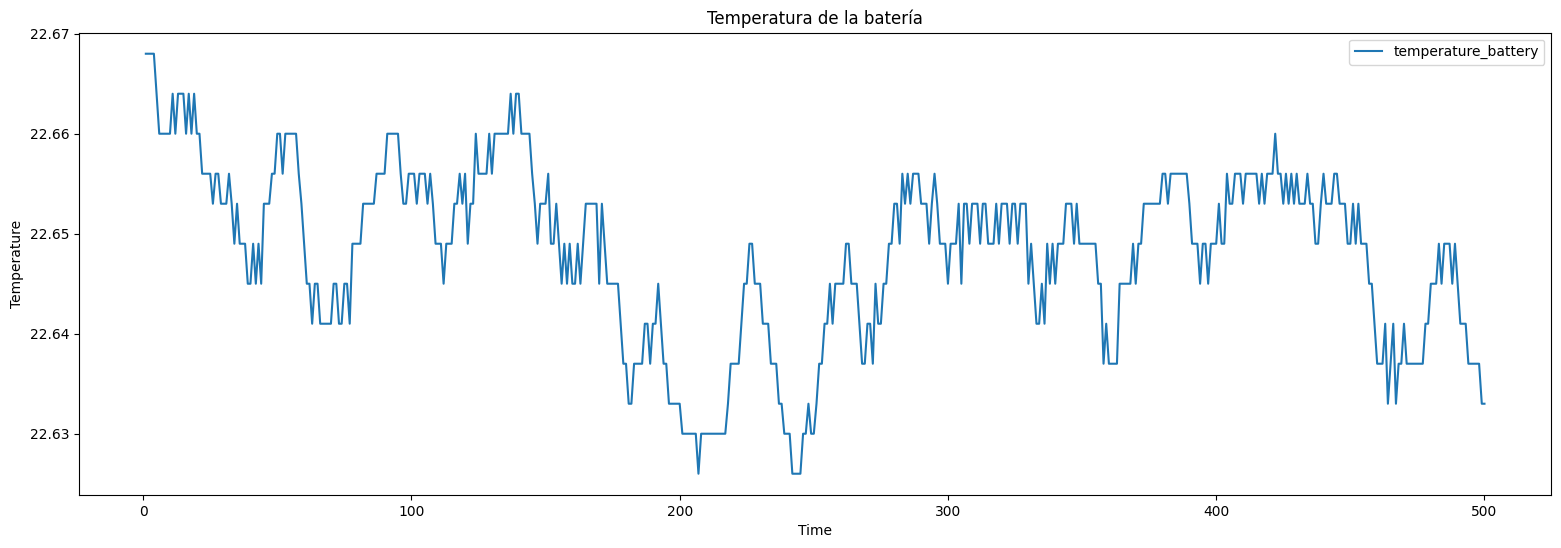

In [9]:
df_temp.plot(
    x = 'obs',
    y = 'temperature_battery',
    figsize=(19, 6)
)
plt.title("Temperatura de la batería")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.show()

In [10]:
df_temp.describe()
# Vamos a usar estos datos como referencia para la corrección de valore nulos

obs          time  temperature_battery
count  500.000000  5.000000e+02           500.000000
mean   250.500000  1.747074e+06            22.648154
std    144.481833  1.477761e+02             0.008685
min      1.000000  1.746819e+06            22.626000
25%    125.750000  1.746946e+06            22.641000
50%    250.500000  1.747074e+06            22.649000
75%    375.250000  1.747201e+06            22.653000
max    500.000000  1.747330e+06            22.668000

# Instrucciónes
Con base en el material entregado en la tarea 2 y lo visto en clase:

1.- Obtener una serie de tiempo generada a partir de algún fenómeno real, que tenga una longitud de al menos 300 muestras; de ser posible seleccionar una serie que presente valores perdidos o outliers.

2.- Introducir arbitrariamente entre 3 y 5 outliers, de los cuales al menos 2 sean valores extremos (muy alejados de la media) y al menos 2 sean valores convencionales pero con comportamiento atípico.

3.- Introducir arbitrariamente de 3 a 5 valores perdidos aislados (no consecutivos), así como 2 segmentos de valores perdidos sucesivos de longitudes de entre 3 y 5 muestras.

4.- Aplicar las técnicas de detección y tratamiento de outliers y de valores perdidos mencionados en la tarea 2.

5.- Mostrar el efecto de las diferentes transformaciones y graficar cada paso.

Analizar los resultados y reportar dicho análisis.

## 2 - Introducir Outliers

5 outliers:

    - 2 valores extremos (muy alejados de la media)
    - 2 convencionales con conportamiento atípico

In [11]:
df_temp.head(10)

obs         time  temperature_battery
0    1  1746819.055               22.668
1    2  1746820.073               22.668
2    3  1746821.115               22.668
3    4  1746822.133               22.668
4    5  1746823.150               22.664
5    6  1746824.174               22.660
6    7  1746825.191               22.660
7    8  1746826.215               22.660
8    9  1746827.233               22.660
9   10  1746828.253               22.660

In [12]:
# 2 valores muy extremos, uno en el tiempo 5 y otro en el 100
df_temp.loc[df_temp['obs'] == 5, 'temperature_battery'] = 22.61      # Extremo
df_temp.loc[df_temp['obs'] == 100, 'temperature_battery'] = 22.62    # Extremo
df_temp.loc[df_temp['obs'] == 300, 'temperature_battery'] = 22.661   # Atípico
df_temp.loc[df_temp['obs'] == 400, 'temperature_battery'] = 22.661   # Atípico

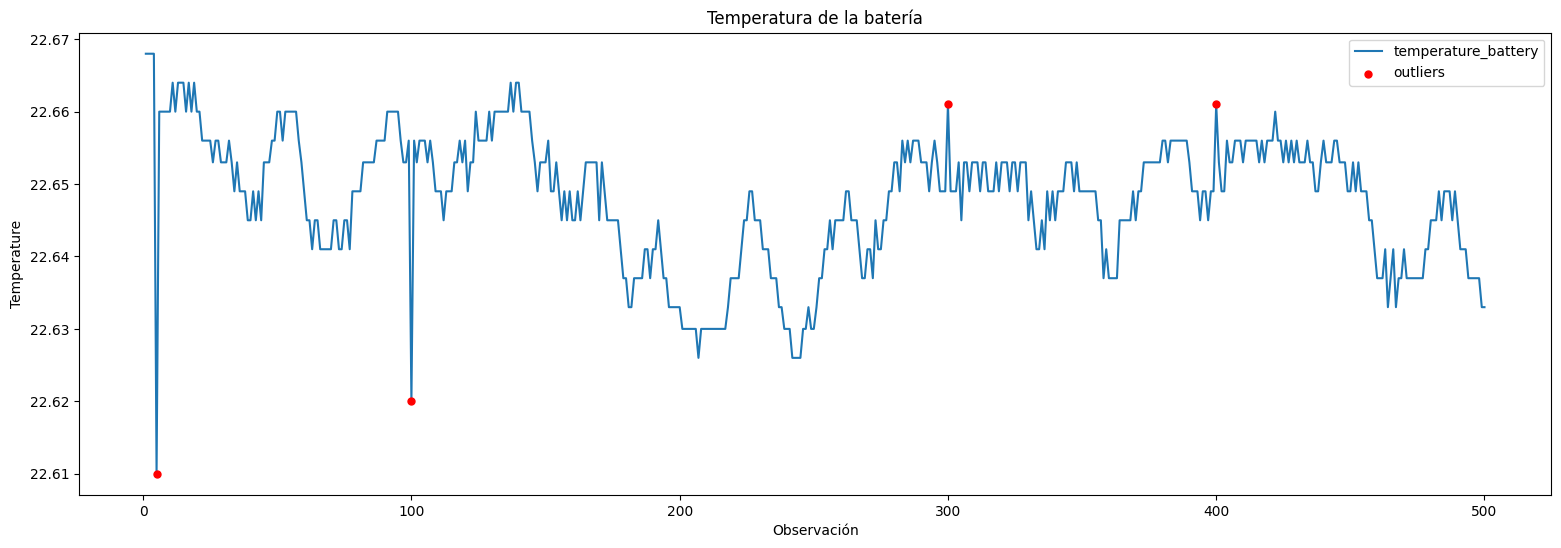

In [13]:
# Serie
ax = df_temp.plot(
    x = 'obs',
    y = 'temperature_battery',
    figsize=(19,6))

# Outliers
outliers = [5, 100, 300, 400]
ax.scatter(
    df_temp.loc[df_temp['obs'].isin(outliers), 'obs'],
    df_temp.loc[df_temp['obs'].isin(outliers), 'temperature_battery'],
    color='red',       
    s=25,            
    zorder=5,         
    label='outliers')

plt.title("Temperatura de la batería")
plt.xlabel("Observación")
plt.ylabel("Temperature")
ax.legend()
plt.show()

## 3 - Valores perdidos

    -   3 valores perdidos aislados no consecutivos
    -   2 segmentos de 5 muestras de valores perdidos

In [14]:
# Vamos a poner los perdidos individuales en 50, 150 y 250
df_temp.loc[df_temp['obs'] == 50, 'temperature_battery'] = np.nan
df_temp.loc[df_temp['obs'] == 150, 'temperature_battery'] = np.nan
df_temp.loc[df_temp['obs'] == 250, 'temperature_battery'] = np.nan

# Vamos a poner las muestras con 5 valores perdidos en 75, 175 y 275
lista = [75, 175, 275]
for valor in lista:
    df_temp.iloc[df_temp.index[valor:valor+5], df_temp.columns.get_loc('temperature_battery')] = np.nan

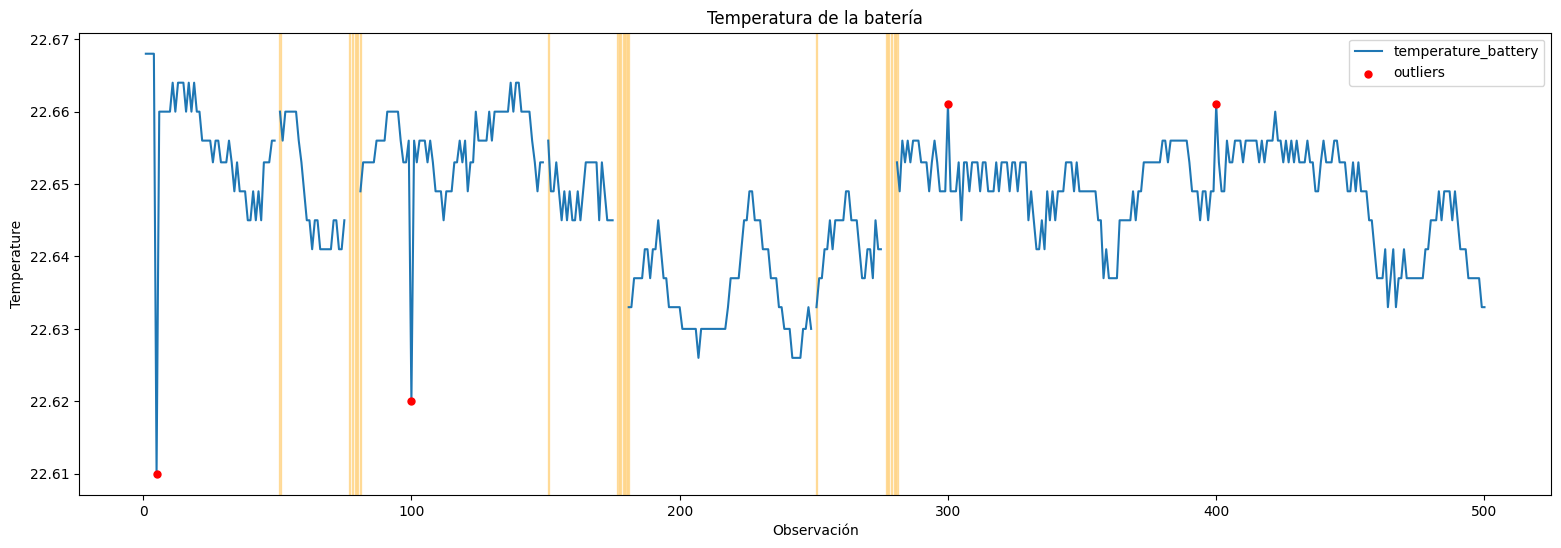

In [15]:
# Serie
ax = df_temp.plot(
    x = 'obs',
    y = 'temperature_battery',
    figsize=(19,6))

# Outliers
outliers = [5, 100, 300, 400]
ax.scatter(
    df_temp.loc[df_temp['obs'].isin(outliers), 'obs'],
    df_temp.loc[df_temp['obs'].isin(outliers), 'temperature_battery'],
    color='red',       
    s=25,            
    zorder=5,         
    label='outliers')

# Perdidos
perdidos = df_temp[df_temp['temperature_battery'].isna()]['obs']
for idx in perdidos:
    ax.axvspan(df_temp.loc[idx, 'obs']-0.2, df_temp.loc[idx, 'obs']+0.2, 
               color='orange', alpha=0.3)

plt.title("Temperatura de la batería")
plt.xlabel("Observación")
plt.ylabel("Temperature")
ax.legend()
plt.show()


## 4 - Detección y tratamiento de outliers y de valores perdidos
    -   Primero se hace imputación de valores nulos
    -   Después se va a aplicar un isolation forest


In [16]:
# Imputación de valores nulos con la media
df_temp['temperature_battery'].describe()

count    482.000000
mean      22.648118
std        0.009001
min       22.610000
25%       22.641000
50%       22.649000
75%       22.653000
max       22.668000
Name: temperature_battery, dtype: float64

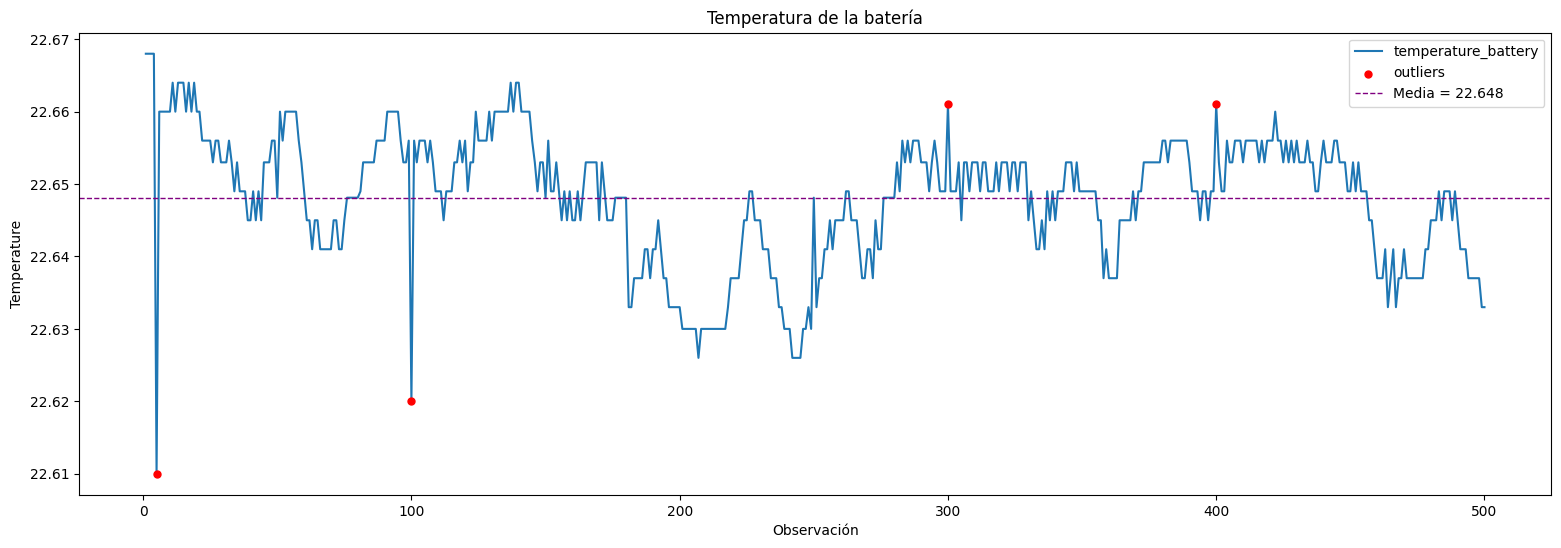

In [17]:
df_temp_media = df_temp['temperature_battery'].mean()
df_temp['temperature_battery'] = df_temp['temperature_battery'].fillna(df_temp_media)

# Serie
ax = df_temp.plot(
    x = 'obs',
    y = 'temperature_battery',
    figsize=(19,6))

# Outliers
outliers = [5, 100, 300, 400]
ax.scatter(
    df_temp.loc[df_temp['obs'].isin(outliers), 'obs'],
    df_temp.loc[df_temp['obs'].isin(outliers), 'temperature_battery'],
    color='red',       
    s=25,            
    zorder=5,         
    label='outliers')

# Media

ax.axhline(y = df_temp_media,
         color='purple',
         linestyle = '--',
         linewidth = 1,
         label = f'Media = {df_temp_media:.3f}')

plt.title("Temperatura de la batería")
plt.xlabel("Observación")
plt.ylabel("Temperature")
ax.legend()
plt.show()

### Deteción de outliers - Tratamiento con Box-Plot

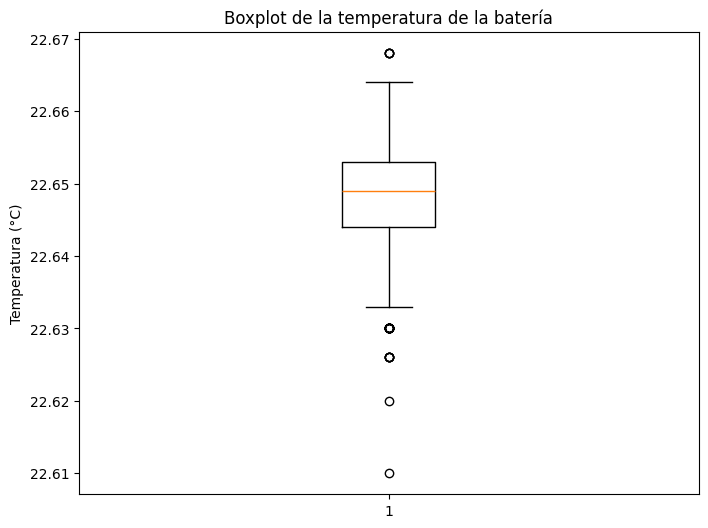

In [18]:
plt.figure(figsize=(8,6))
plt.boxplot(df_temp['temperature_battery'])
plt.title("Boxplot de la temperatura de la batería")
plt.ylabel("Temperatura (°C)")
plt.show()
# Como podemos ver, hay mas outliers identificados del lado inferior que del lado superior, entonces en un primer experimento vamos a eliminarlos y ver
# La nueva longitud de la serie resultante.

In [19]:
# Eliminación de los outliers
Q1 = df_temp['temperature_battery'].quantile(0.25)
Q3 = df_temp['temperature_battery'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1-1.5 * IQR
limite_superior = Q3+1.5 * IQR

df_box_plot = df_temp[(df_temp['temperature_battery'] >= limite_inferior) &
                          (df_temp['temperature_battery'] <= limite_superior)].copy()

df_box_plot.shape

(467, 3)

In [20]:
df_box_plot['temperature_battery'].describe()

count    467.000000
mean      22.649180
std        0.007317
min       22.633000
25%       22.645000
50%       22.649000
75%       22.653000
max       22.664000
Name: temperature_battery, dtype: float64

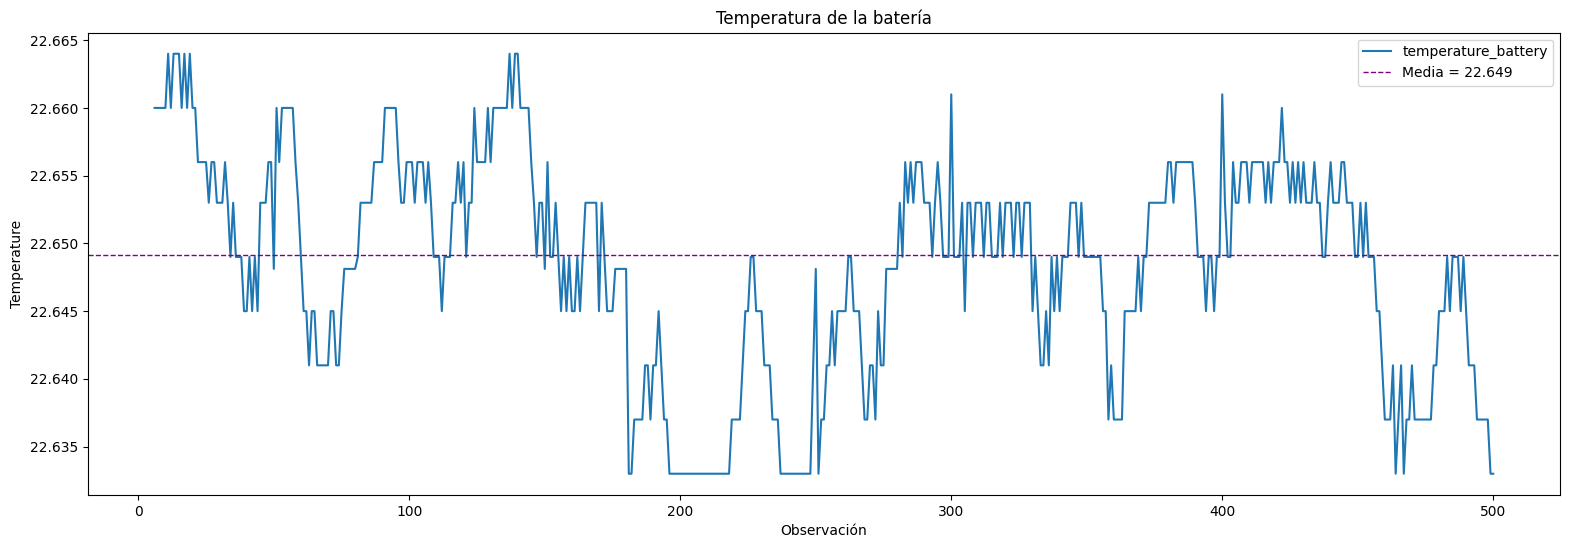

In [21]:
df_box_plot_media = df_box_plot['temperature_battery'].mean()
df_box_plot['temperature_battery'] = df_box_plot['temperature_battery'].fillna(df_box_plot_media)

# Serie
ax = df_box_plot.plot(
    x = 'obs',
    y = 'temperature_battery',
    figsize=(19,6))

# Media
ax.axhline(y = df_box_plot_media,
         color='purple',
         linestyle = '--',
         linewidth = 1,
         label = f'Media = {df_box_plot_media:.3f}')

plt.title("Temperatura de la batería")
plt.xlabel("Observación")
plt.ylabel("Temperature")
ax.legend()
plt.show()

In [22]:
print(f'Se eliminaron {len(df_temp) - len(df_box_plot)} valores registrados como outliers usando BoxPlots')
# Creo que fueron demasiados

Se eliminaron 33 valores registrados como outliers usando BoxPlots


### Detección de outliers - Tratamiento a ojo de buen cubero

Usando el BoxPlot se fueron muchos datos que yo pensaría que son normales aún, asi que ahora voy a ver como queda la serie si los elimino por vista

In [23]:
df_ojo = df_temp[(df_temp['temperature_battery'] <= 22.666) & 
                 (df_temp['temperature_battery'] >= 22.620)].copy()

df_ojo_media = df_ojo['temperature_battery'].mean()
df_ojo['temperature_battery'].describe()



count    495.000000
mean      22.648035
std        0.008529
min       22.620000
25%       22.643000
50%       22.649000
75%       22.653000
max       22.664000
Name: temperature_battery, dtype: float64

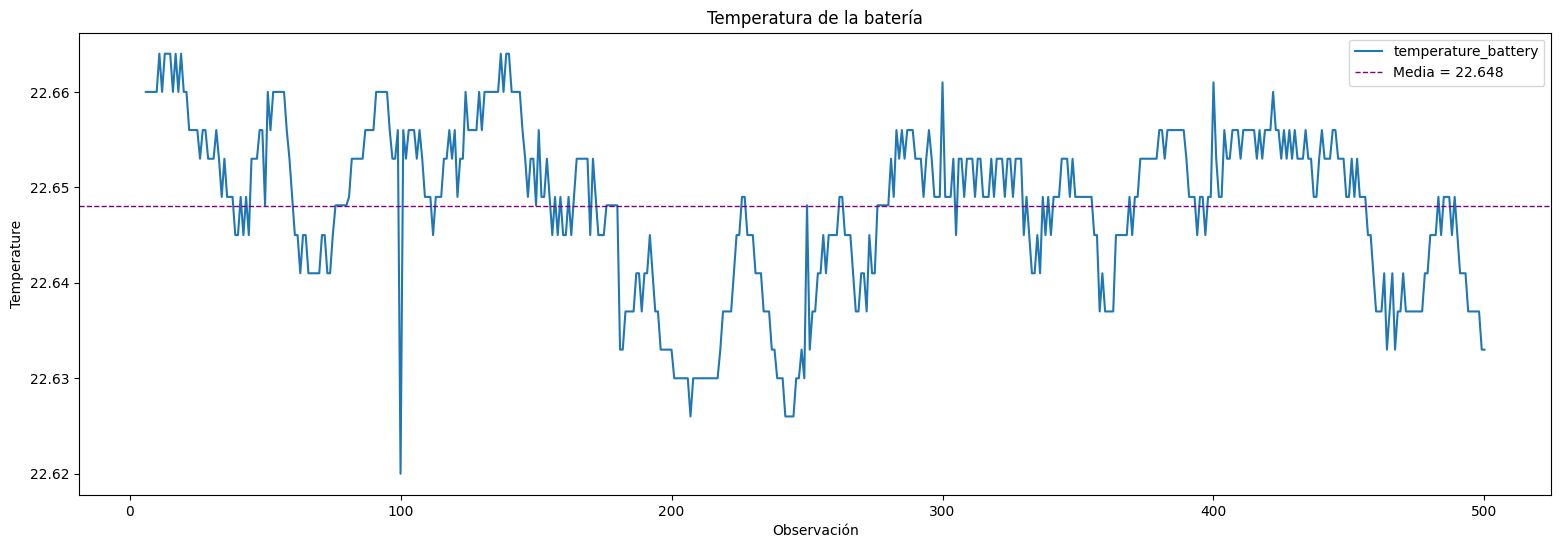

In [24]:
# Serie
ax = df_ojo.plot(
    x = 'obs',
    y = 'temperature_battery',
    figsize=(19,6))

# Media
ax.axhline(y = df_ojo_media,
         color='purple',
         linestyle = '--',
         linewidth = 1,
         label = f'Media = {df_ojo_media:.3f}')

plt.title("Temperatura de la batería")
plt.xlabel("Observación")
plt.ylabel("Temperature")
ax.legend()
plt.show()


In [25]:
print(f'Se eliminaron {len(df_temp) - len(df_ojo)} valores registrados como outliers a puro ojo')
# Creo que fueron demasiados

Se eliminaron 5 valores registrados como outliers a puro ojo


### Detección de outliers aplicando z-score

Otra de las maneras en las que se pueden detectar los outliers es mediante el uso del z-score

In [26]:
desviacion_std = 3 # más allá de 3 desviaciónes estándar
df_zscores = df_temp.copy()
df_zscores['z_score'] = stats.zscore(df_zscores['temperature_battery'])
df_zscores.head()

obs         time  temperature_battery   z_score
0    1  1746819.055               22.668  2.252023
1    2  1746820.073               22.668  2.252023
2    3  1746821.115               22.668  2.252023
3    4  1746822.133               22.668  2.252023
4    5  1746823.150               22.610 -4.317689

In [27]:
outliers_z_score = df_zscores[np.abs(df_zscores['z_score']) > desviacion_std] 
df_zscores = df_zscores[np.abs(df_zscores['z_score']) <= desviacion_std]
df_zscores.shape

(498, 4)

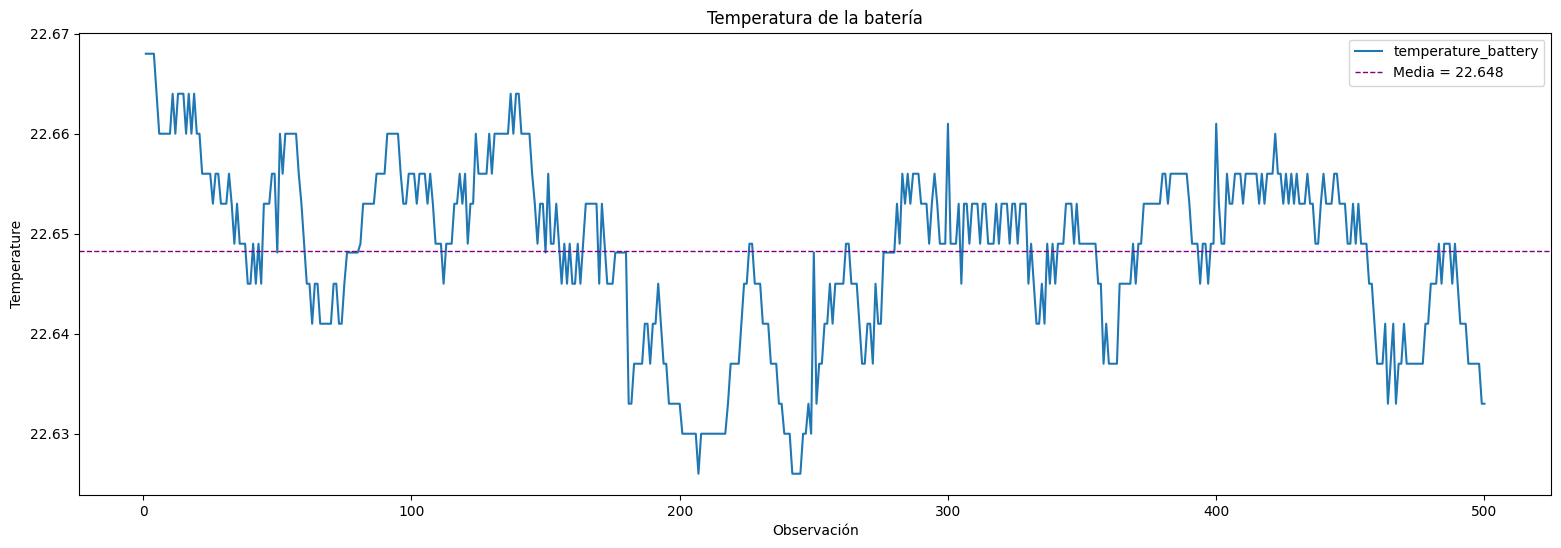

In [28]:
# Serie
df_zscores_media = df_zscores['temperature_battery'].mean()
ax = df_zscores.plot(
    x = 'obs',
    y = 'temperature_battery',
    figsize=(19,6))

# Media
ax.axhline(y = df_zscores_media,
         color='purple',
         linestyle = '--',
         linewidth = 1,
         label = f'Media = {df_zscores_media:.3f}')

plt.title("Temperatura de la batería")
plt.xlabel("Observación")
plt.ylabel("Temperature")
ax.legend()
plt.show()

In [29]:
print(f'Se eliminaron {len(df_temp) - len(df_zscores)} valores registrados como outliers usando z-score')

Se eliminaron 2 valores registrados como outliers usando z-score


### Detección de outliers aplicando Media Móvil

Aplicando un enfoque de ir moviendo la media y eliminar de acuerdo a las desviaciónes estandar

In [40]:
df_movil = df_temp.copy()
ventana = 10

df_movil['media_movil'] = df_movil['temperature_battery'].rolling(window=ventana, center=True).mean()
df_movil['std_movil'] = df_movil['temperature_battery'].rolling(window=ventana, center = True).std()

desviaciones = 2
df_movil['outlier_movil'] = ((df_movil['temperature_battery'] - df_movil['media_movil']).abs()
                             > df_movil['std_movil'] * desviaciones) 

df_movil.head(10)

obs         time  temperature_battery  media_movil  std_movil  \
0    1  1746819.055               22.668          NaN        NaN   
1    2  1746820.073               22.668          NaN        NaN   
2    3  1746821.115               22.668          NaN        NaN   
3    4  1746822.133               22.668          NaN        NaN   
4    5  1746823.150               22.610          NaN        NaN   
5    6  1746824.174               22.660      22.6582   0.017396   
6    7  1746825.191               22.660      22.6578   0.017190   
7    8  1746826.215               22.660      22.6570   0.016846   
8    9  1746827.233               22.660      22.6566   0.016601   
9   10  1746828.253               22.660      22.6562   0.016342   

   outlier_movil  
0          False  
1          False  
2          False  
3          False  
4          False  
5          False  
6          False  
7          False  
8          False  
9          False

In [41]:
df_movil['outlier_movil'].value_counts()

outlier_movil
False    494
True       6
Name: count, dtype: int64

In [45]:
df_movil_normales = df_movil[df_movil['outlier_movil'] == False]
df_movil_outlier = df_movil[df_movil['outlier_movil'] == True]

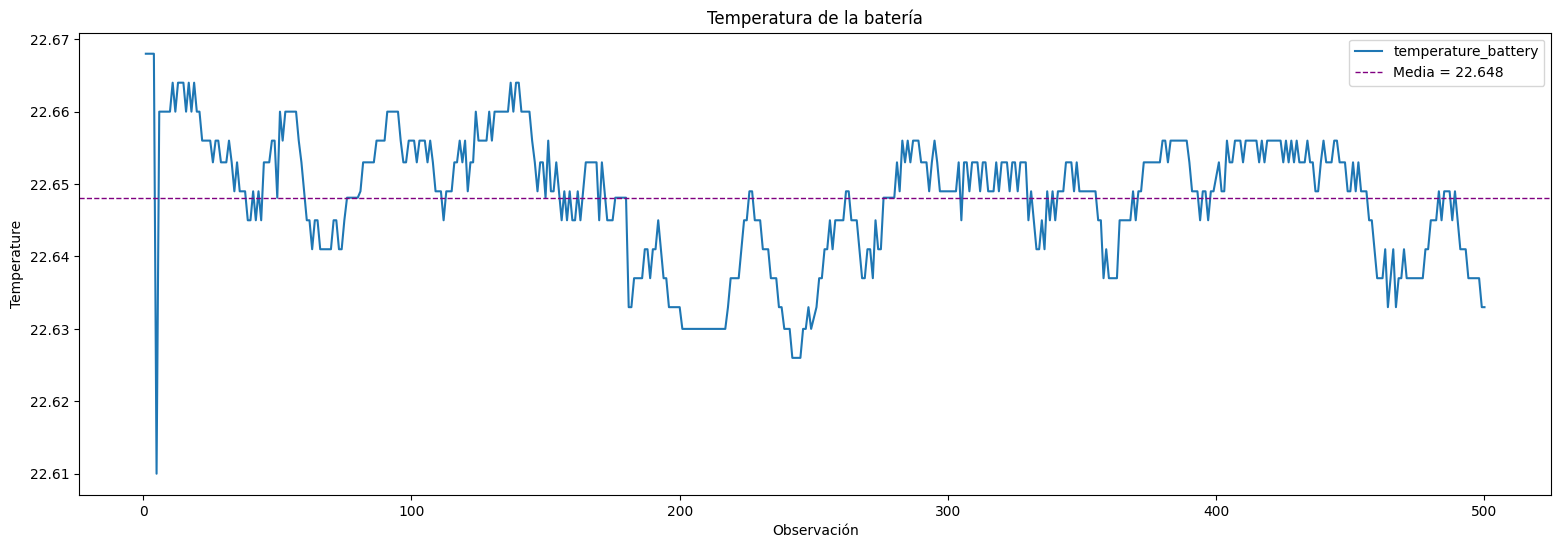

In [47]:
# Serie
df_movil_normales_media = df_movil_normales['temperature_battery'].mean() 
ax = df_movil_normales.plot(
    x = 'obs',
    y = 'temperature_battery',
    figsize=(19,6))

# Media
ax.axhline(y = df_movil_normales_media,
         color='purple',
         linestyle = '--',
         linewidth = 1,
         label = f'Media = {df_movil_normales_media:.3f}')

plt.title("Temperatura de la batería")
plt.xlabel("Observación")
plt.ylabel("Temperature")
ax.legend()
plt.show()

In [46]:
print(f'Se eliminaron {len(df_temp) - len(df_movil_normales)} valores registrados como outliers usando una Media Movil son 2 std')

Se eliminaron 6 valores registrados como outliers usando una Media Movil son 2 std


### Detección de outliers aplicando Isolation Forest|

Aplicando un enfoque de Cómputo Inteligente

In [32]:
df_IF = df_temp.copy()
X = df_IF[['temperature_battery']]
iso = IsolationForest(contamination=0.05, random_state=42)
df_IF['IF'] = iso.fit_predict(X)
df_IF.head()

obs         time  temperature_battery  IF
0    1  1746819.055               22.668  -1
1    2  1746820.073               22.668  -1
2    3  1746821.115               22.668  -1
3    4  1746822.133               22.668  -1
4    5  1746823.150               22.610  -1

In [33]:
# 1 es normal, -1 es outlier
df_IF_normales = df_IF[df_IF['IF'] == 1]
df_IF_outliers = df_IF[df_IF['IF'] != 1]
df_IF.shape

(500, 4)

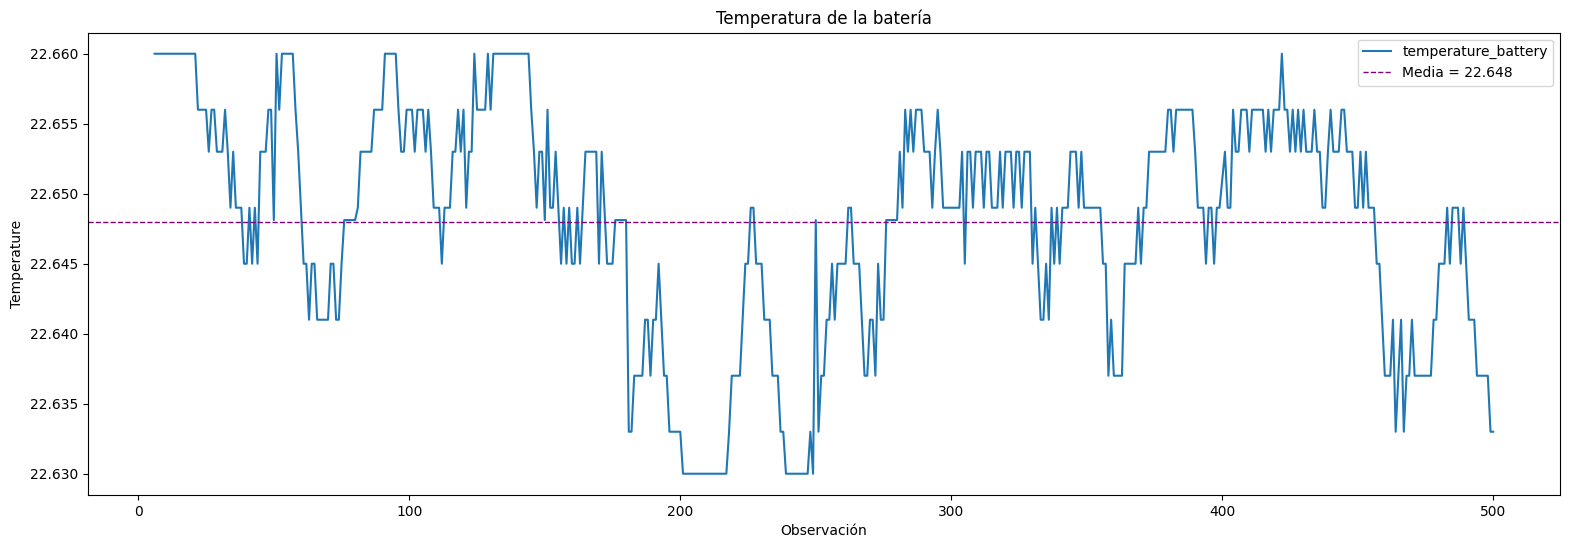

In [34]:
# Serie
df_IF_normales_media = df_IF_normales['temperature_battery'].mean() 
ax = df_IF_normales.plot(
    x = 'obs',
    y = 'temperature_battery',
    figsize=(19,6))

# Media
ax.axhline(y = df_IF_normales_media,
         color='purple',
         linestyle = '--',
         linewidth = 1,
         label = f'Media = {df_IF_normales_media:.3f}')

plt.title("Temperatura de la batería")
plt.xlabel("Observación")
plt.ylabel("Temperature")
ax.legend()
plt.show()

In [35]:
print(f'Se eliminaron {len(df_temp) - len(df_IF)} valores registrados como outliers usando IF')

Se eliminaron 0 valores registrados como outliers usando IF
